In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
# 2b
data = np.genfromtxt('clase_8_dataset.csv', delimiter=',')
print(data.shape)

(500, 2)


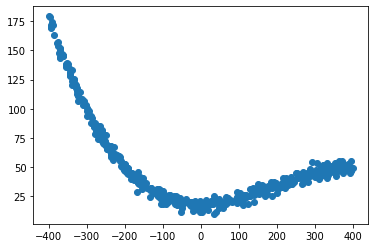

In [3]:
# 2c
plt.scatter(data[:, 0], data[:, 1])

In [4]:
# 2d

def split_dataset(dataset, train=70, validate=20):
    """
    This function splits a dataset into training, validation and testing
    
    :param dataset: the dataset to be split
    :param train: the percentage of the samples to be used for training, expressed as percentage
    :param validate: the percentage of the samples to be used for validation, expressed as percentage.
        The remaining of training and validation is used for testing
    :return:
        - Training set
        - Validation set
        - Testing set (might be empty)
    """
    
    # Validate input and calculate testing percentage
    if train >= 100:
        return None
    if train + validate > 100:
        validate = 100 - train
    test = 100 - train - validate
    
    # Get the indexes for splitting the dataset
    n_elements = dataset.shape[0]
    train_lim = int(n_elements * train / 100)
    validate_lim = int(n_elements * (train + validate) / 100)
    
    # Permutate and split the dataset and return it
    dataset = np.random.permutation(dataset)
    return(dataset[:train_lim], dataset[train_lim:validate_lim], dataset[validate_lim:])

train, test, _ = split_dataset(data, train=80, validate=20)
print(train.shape, test.shape)

(400, 2) (100, 2)


866.7814662104578


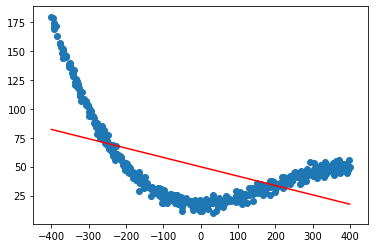

In [5]:
# 3a

def powers(X, orden):
    # Calculo los arrays con las potencias de X que son necesarias para la regresión polinómica
    X_pow = np.empty((X.shape[0], orden + 1))
    X_pow[:, 0] = 1
    X_pow[:, 1] = X
    for i in range(2, orden + 1):
        X_pow[:, i] = X ** i
    return X_pow
    
def poly_regression_closed(X, y, orden):
    # Calculo los coeficientes del polinomio y los devuelvo
    X_pow = powers(X, orden)
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X_pow.T, X_pow)), X_pow.T), y)

def predict(coeffs, value):
    # Predice el valor del modelo para los coeficientes dados y la abscisa dada
    return sum([c * value ** j for j, c in enumerate(coeffs)])

def plot_line(coeffs, min_range=-400, max_range=400, step=1):
    # Plotea una linea con las predicciones para el rango establecido
    linea = []
    for i in range(min_range, max_range, step):
        linea.append(predict(coeffs, i))
    plt.plot(range(min_range, max_range, step), linea, 'r')
    plt.scatter(data[:, 0], data[:, 1])

def mse(truth, prediction):
        return np.mean((truth.flatten() - prediction.flatten()) ** 2)
    
def k_folds(
        X_train,
        y_train,
        k=5,
        fit_method=poly_regression_closed,
        param_fit=1,
        predict_method=predict,
        error_method=mse
):
    chunk_size = int(len(X_train) / k)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        coeffs = fit_method(new_X_train, new_y_train, param_fit)
        prediction = predict_method(coeffs, new_X_valid)
        mse_list.append(error_method(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)
    return mean_MSE
    
# Separo la entrada de la salida
X = train[:, 0]
y = train[:, 1]

# Mostrar el MSE promedio
print(k_folds(X, y))

# Mostrar la gráfica de la predicción
coeffs = poly_regression_closed(X, y, 1)
plot_line(coeffs)

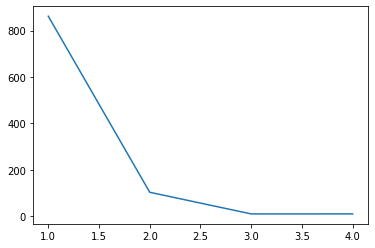

In [6]:
# 3b
cost = [861.7]  # Lo inicio con el peso del inciso anterior
for i in range(2, 5):
    cost.append(k_folds(X, y, param_fit=i))
    
plt.plot(range(1, 5), cost)

3c

A juzgar por el gráfico anterior parecería tener sentido usar el polinomio de orden 3, dado que el de orden 4 no presenta mejoras apreciables respecto a la reducción del costo y tendría mayores chances de presentar overfitting. Si el de orden 3 tuviera overfitting, el de orden 2 parece una buena alternativa también.

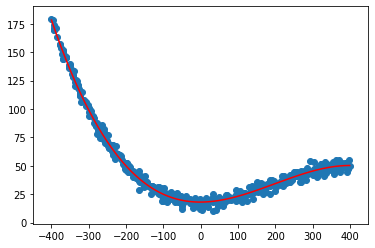

In [7]:
# 3d

# Mostramos la aproximación polinómica de orden 3 junto con la nube de puntos
coeffs = poly_regression_closed(X, y, 3)
plot_line(coeffs)


La gráfica anterior parece confirmar que la elección del polinomio de orden 3 es acertada.

In [8]:
# 4a

def mini_batch_gradient_descent(X_train, y_train, X_validation, y_validation, lr=0.1, amt_epochs=200):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 8
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)

    training_error = []
    validation_error = []
    for i in range(amt_epochs):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        batch_size = int(len(X_train) / b)
        for j in range(0, len(X_train), batch_size):
            end = j + batch_size if j + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[j: end, :]
            batch_y = y_train[j: end, :]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(error * batch_X, axis=0)
            grad_mul = -2/n * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)
        
        t_error = np.mean(error ** 2)
        training_error.append(t_error)
        v_error = np.mean((y_validation - np.matmul(X_validation, W)) ** 2)
        validation_error.append(v_error)
        print('Epoch {}, training error: {}'.format(i + 1, t_error))
        print('Epoch {}, validation error: {}'.format(i + 1, v_error))

    return W, training_error, validation_error


In [9]:
# Calculo los arrays con las potencias de X que son necesarias para la regresión polinómica
X_pow = powers(X, 3)
    
# Tomar las medias y las desviaciones estándar de modo de normalizar los datos
X_mean = np.mean(X_pow, axis=0).reshape((1, 4))
X_std = np.std(X_pow, axis=0).reshape((1, 4))
y_mean = np.mean(y)
y_std = np.std(y)

# A la columna correspondiente al offset no la voy a normalizar, dado que al tener varianza nula me dará NaN al dividir
X_std[0, 0] = 1
X_mean[0, 0] = 0

# Normalizo los datos de entrada y salida
X_normalized = (X_pow - X_mean) / X_std
y_normalized = ((y - y_mean) / y_std).reshape((-1, 1))

# Normalizo también el set de validación, de modo de poder ver el error de validación a lo largo del proceso
X_v_normalized = (powers(test[:, 0], 3) - X_mean) / X_std
y_v_normalized = ((test[:, 1] - y_mean) / y_std).reshape((-1, 1))

# Ejecuto el mini batch gradient descent
W, training_error, validation_error = mini_batch_gradient_descent(X_normalized, y_normalized, X_v_normalized, y_v_normalized)


Epoch 1, training error: 6.839423886145445
Epoch 1, validation error: 6.636933644701365
Epoch 2, training error: 5.632933148200403
Epoch 2, validation error: 4.3653037215022366
Epoch 3, training error: 3.177798153273441
Epoch 3, validation error: 2.9328580922024536
Epoch 4, training error: 2.5953245596386627
Epoch 4, validation error: 2.011458885504805
Epoch 5, training error: 1.0473597536898458
Epoch 5, validation error: 1.4096869640132517
Epoch 6, training error: 1.1218491925085652
Epoch 6, validation error: 1.0116527376544093
Epoch 7, training error: 0.7813318888648193
Epoch 7, validation error: 0.7484422258590638
Epoch 8, training error: 0.6979168075764016
Epoch 8, validation error: 0.5724495034302279
Epoch 9, training error: 0.46619323026415427
Epoch 9, validation error: 0.4531974093916956
Epoch 10, training error: 0.434005219799291
Epoch 10, validation error: 0.3714162530380747
Epoch 11, training error: 0.3222296565315692
Epoch 11, validation error: 0.31518332565465157
Epoch 12, 

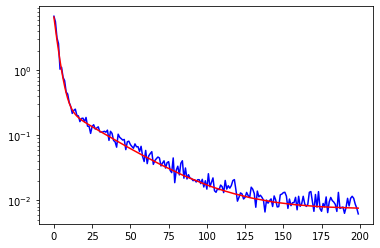

In [10]:
# 4b

plt.plot(training_error, 'b')
plt.plot(validation_error, 'r')
plt.yscale('log')

In [11]:
# 4c

# Calculo el MSE entre las muestras originales y la aproximación utilizando la fórmula cerrada
prediction_closed = mse(test[:, 1], np.matmul(powers(test[:, 0], 3), coeffs))

# Calculo los valores obtenidos utilizando gradient descent, teniendo en cuenta la normalización utilizada
# X_powers = powers(test[:, 0], 3)
# X_normalized = (X_powers - X_mean) / X_std
y_gradient_normalized = np.matmul(X_v_normalized, W)
y_grad_descent = y_gradient_normalized * y_std + y_mean

# Calculo el MSE entre las muestras originales y la aproximación utilizando la fórmula cerrada
prediction_iterative = mse(test[:, 1], y_grad_descent)

print('El MSE para el método cerrado fue de {} y el obtenido usando gradient descent fue de {}'.format(
    prediction_closed,
    prediction_iterative,
))


El MSE para el método cerrado fue de 8.959541506041722 y el obtenido usando gradient descent fue de 9.214336064007727


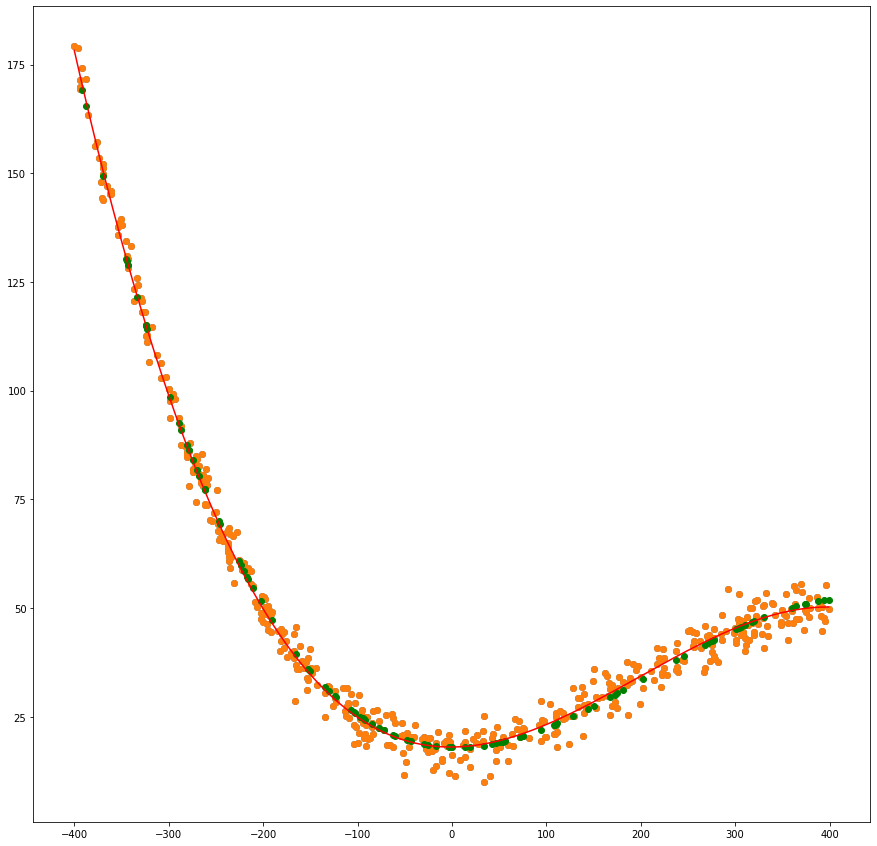

In [12]:
# Muestro simultaneamente las muestras originales (puntos naranja), las generadas con gradient descent ( puntos verdes)
# y el polinomio generado usando el método cerrado (línea roja)
plt.figure(figsize=(15,15))
plot_line(coeffs)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(test[:, 0], y_grad_descent[:, 0], c='g')
plt.show()

Como se puede ver en la comparación de los errores cometidos en cada método y en la gráfica posterior, los resultados conseguidos con ambos métodos son muy parecidos. Desde luego es preferible, siempre que sea posible, usar la fórmula cerrada. La misma logra resultados óptimos con sólo una iteración, mientras que con el método de gradiente descendiente fueron necesarias 200 epochs.

In [13]:
# 5a

def mini_batch_gradient_descent_ridge(X_train, y_train, X_validation, y_validation, lr=0.1, amt_epochs=200, lbda=0.02):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 8
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)

    training_error = []
    validation_error = []
    for i in range(amt_epochs):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        batch_size = int(len(X_train) / b)
        for j in range(0, len(X_train), batch_size):
            end = j + batch_size if j + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[j: end, :]
            batch_y = y_train[j: end, :]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(error * batch_X, axis=0)
            grad_mul = -2/n * grad_sum + 2 * lbda * W.T # 1xm  <-- acá está la única diferencia con respecto a antes
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)
        
        t_error = np.mean(error ** 2)
        training_error.append(t_error)
        v_error = np.mean((y_validation - np.matmul(X_validation, W)) ** 2)
        validation_error.append(v_error)
        print('Epoch {}, training error: {}'.format(i + 1, t_error))
        print('Epoch {}, validation error: {}'.format(i + 1, v_error))

    return W, training_error, validation_error

In [14]:
# Ejecuto el mini batch gradient descent usando ridge
W_ridge, training_error_ridge, validation_error_ridge = mini_batch_gradient_descent_ridge(
    X_normalized, y_normalized, X_v_normalized, y_v_normalized)


Epoch 1, training error: 4.443719319938308
Epoch 1, validation error: 4.727045910676439
Epoch 2, training error: 2.8653350137526985
Epoch 2, validation error: 2.824928251802598
Epoch 3, training error: 1.7699390986801262
Epoch 3, validation error: 1.6997678845483666
Epoch 4, training error: 1.0202881508041535
Epoch 4, validation error: 1.0285540231024293
Epoch 5, training error: 0.5368938590439988
Epoch 5, validation error: 0.6244381645716524
Epoch 6, training error: 0.3612143891516429
Epoch 6, validation error: 0.38086827043774135
Epoch 7, training error: 0.26265223382203595
Epoch 7, validation error: 0.23405266301168148
Epoch 8, training error: 0.16214927472803167
Epoch 8, validation error: 0.14541124341151246
Epoch 9, training error: 0.09621561466447939
Epoch 9, validation error: 0.09242758401569727
Epoch 10, training error: 0.05626205233113989
Epoch 10, validation error: 0.06133585312640454
Epoch 11, training error: 0.043792334165389676
Epoch 11, validation error: 0.043167936754308

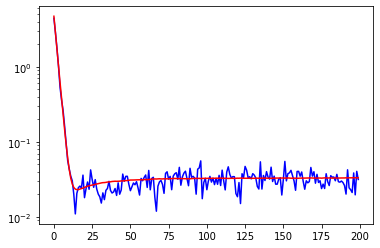

In [15]:
# Ploteo los datos del entrenamiento
plt.plot(training_error_ridge, 'b')
plt.plot(validation_error_ridge, 'r')
plt.yscale('log')

A raiz del gráfico anterior, voy a re-entrenar, cortando en la epoch 17, que es donde se da el mínimo error para el dataset de testing.

In [19]:
# Ejecuto el mini batch gradient descent usando ridge
W_ridge, training_error_ridge, validation_error_ridge = mini_batch_gradient_descent_ridge(
    X_normalized, y_normalized, X_v_normalized, y_v_normalized, amt_epochs=17)

Epoch 1, training error: 2.2083574370253367
Epoch 1, validation error: 2.2796485194383593
Epoch 2, training error: 1.3649911946370918
Epoch 2, validation error: 1.4013704471507331
Epoch 3, training error: 0.9614724296002806
Epoch 3, validation error: 0.8760815823799368
Epoch 4, training error: 0.6089619587726108
Epoch 4, validation error: 0.556832429305045
Epoch 5, training error: 0.3642252721602199
Epoch 5, validation error: 0.35990895013562946
Epoch 6, training error: 0.24746119701737346
Epoch 6, validation error: 0.23727754734712397
Epoch 7, training error: 0.15022599694803485
Epoch 7, validation error: 0.16102862327757708
Epoch 8, training error: 0.16797036750201363
Epoch 8, validation error: 0.11275828645317597
Epoch 9, training error: 0.07565575082283008
Epoch 9, validation error: 0.08212419979608747
Epoch 10, training error: 0.06253019443727172
Epoch 10, validation error: 0.0628556417937673
Epoch 11, training error: 0.06777717000081124
Epoch 11, validation error: 0.0505528694492

In [21]:
# Calculo los valores obtenidos utilizando gradient descent con ridge, teniendo en cuenta la normalización utilizada
y_normalized_ridge = np.matmul(X_v_normalized, W_ridge)
y_grad_descent_ridge = y_normalized_ridge * y_std + y_mean

# Calculo el MSE entre las muestras originales y la aproximación utilizando la fórmula cerrada
prediction_ridge = mse(test[:, 1], y_grad_descent_ridge)

print('El MSE obtenido usando gradient descent fue de {} y el obtenido agregando Ridge fue de {}'.format(
    prediction_iterative,
    prediction_ridge,
))

El MSE obtenido usando gradient descent fue de 9.214336064007727 y el obtenido agregando Ridge fue de 36.2568063642755


Al comparar el resultado obtenido con Ridge en relación al anterior, se puede ver que el MSE aumenta considerablemente, aunque la cantidad de iteraciones que fueron necesarias para alcanzar el menor error posible fueron menos. De cualquier manera, era de esperar algo así, dado que el modelo previo no presentaba problemas de overfitting, que son los que serían solucionados mediante el uso de regularización. Es por esto que la regularización no generó mejores resultados.